# RESOLUTION

#### small version of the resolution testing notebook with example given, tests impact of resolution on output

## Imports

In [17]:
%matplotlib inline
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, graphics
import os
import pandas as pd

## Lists and stuff

In [18]:
#products_dir = '/home/pelto/Desktop/ice_thick/alt_dem/' 
num = 5
rgi_list = ['RGI60-02.07780', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.04264', 'RGI60-02.03688', 'RGI60-02.00147', 'RGI60-02.03411']
glacier = ['zillmer', 'haig', 'conrad', 'nordic', 'illecillewaet', 'kokanee', 'W.Washmawapta']

## Initializing other stuff

In [19]:
WORKING_DIR = utils.gettempdir(glacier[num] + '_srtm_dem_resolution') # Let's make a working directory for this DEM 
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

2019-10-21 12:54:28: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


## Lets run it at a high resolution (20)

... and print out the volume to have a numerical value to compare

2019-10-21 12:54:29: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-10-21 12:54:29: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-10-21 12:54:30: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-10-21 12:54:30: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-10-21 12:54:30: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-10-21 12:54:30: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-10-21 12:54:30: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-10-21 12:54:30: oggm.workflo

64.09670826872319
rgi_id
RGI60-02.00147    0.09109
Name: inv_volume_km3, dtype: float64


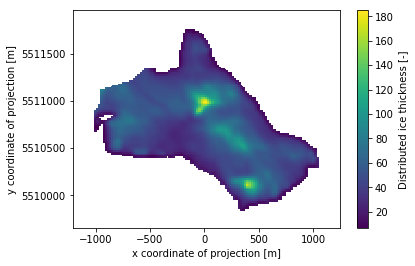

In [20]:
res=20

smooth = 21.

cfg.PARAMS['border'] = 10
cfg.PARAMS['smooth_window'] = smooth

cfg.PARAMS['grid_dx_method'] = 'fixed'
cfg.PARAMS['fixed_dx'] = res


rgidf = utils.get_rgi_glacier_entities([rgi_list[num]])
gdirs = workflow.init_glacier_regions(rgidf)

suf = '_{:03d}_resolution'.format(int(res)) 
workflow.gis_prepro_tasks(gdirs) #shortcut function: run all flowline preprocessing tasks.
workflow.climate_tasks(gdirs) #shortcut function: run all climate related tasks
workflow.inversion_tasks(gdirs) #shortcut function: run all ice thickness inversion tasks
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
gdir = gdirs[0]
tasks.init_present_time_glacier(gdir) # Merges data from preprocessing tasks. First task after inversion! This 
                    ##updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.


ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

ds_new.distributed_thickness.plot()

mfl=gdir.read_pickle('model_flowlines')
thickness= mfl[-1].surface_h - mfl[-1].bed_h
thickness=thickness[thickness>0].mean()
print(thickness)

df  = utils.compile_glacier_statistics(gdirs, inversion_only=True)
volume=df['inv_volume_km3']

print(volume)

## ... and now run it at coarse resolution (200)

... and print out the Volume to have a numerical value to compare too.

2019-10-21 12:54:34: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-10-21 12:54:34: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-10-21 12:54:34: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-10-21 12:54:34: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-10-21 12:54:34: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-10-21 12:54:34: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-10-21 12:54:34: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-10-21 12:54:35: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-10-21 12:54:35: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-10-21 12:54:36

61.874127892931405
rgi_id
RGI60-02.00147    0.093412
Name: inv_volume_km3, dtype: float64


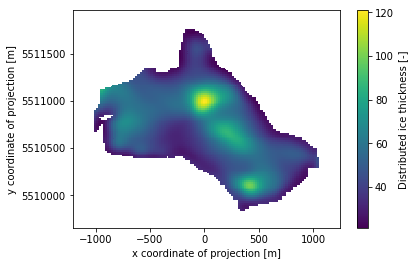

In [21]:
res=200

smooth = 201.

cfg.PARAMS['border'] = 10
cfg.PARAMS['smooth_window'] = smooth

cfg.PARAMS['grid_dx_method'] = 'fixed'
cfg.PARAMS['fixed_dx'] = res

rgidf = utils.get_rgi_glacier_entities([rgi_list[num]])
gdirs = workflow.init_glacier_regions(rgidf)

suf = '_{:03d}_resolution'.format(int(res)) 
workflow.gis_prepro_tasks(gdirs) #shortcut function: run all flowline preprocessing tasks.
workflow.climate_tasks(gdirs) #shortcut function: run all climate related tasks
workflow.inversion_tasks(gdirs) #shortcut function: run all ice thickness inversion tasks
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
gdir = gdirs[0]
tasks.init_present_time_glacier(gdir) # Merges data from preprocessing tasks. First task after inversion! This 
                    ##updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.


ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

ds_new.distributed_thickness.plot()

mfl=gdir.read_pickle('model_flowlines')
thickness= mfl[-1].surface_h - mfl[-1].bed_h
thickness=thickness[thickness>0].mean()
print(thickness)

df  = utils.compile_glacier_statistics(gdirs, inversion_only=True)
volume=df['inv_volume_km3']

print(volume)